## Exercise 1.1 - Dimensionality Reduction of Hyperspectral Data


### Nikolaos Kordalis


Assignment: Provide (1) your python code for analyzing the SST data, (2) a figure showing the first three PCA components, with labels and colorbars, and (3) an explanation of the patterns you see on your maps. Think about what processes might explain the main variance in SST, and how they related to the images you have generated. (30 points)

**Question 1:** For the purposes of this exercise, the data for the mean Sea Surface Temperature for the years 1981-2020 were used: https://www.esrl.noaa.gov/psd/data/gridded/data.cobe.html

First the data were a little bit explored, in order to find out the variables and dimensions.

In [1]:
import gdal
from netCDF4 import Dataset
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize
import dask.array as da
from dask_ml.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
dataset = Dataset('sst.mon.mean.nc', 'r')
print(dataset.variables.keys()) 

odict_keys(['lat', 'lon', 'time', 'sst'])


In [3]:
print(dataset.variables['sst'].dimensions)
print(dataset.variables['sst'].shape)

('time', 'lat', 'lon')
(1551, 180, 360)


In [4]:
sst = dataset.variables['sst'][:]
sst_data = sst.data

However, when we keep only the data part of the masked array, the missing values are automatically replaced by an large number (1e+20). So first, we will replace this large numbers with NaN:

In [6]:
sst_data[sst.mask == True] = np.nan

We have to keep in mind that the missing values may be attributed to 'real' missing data or to the continents. 

That's why the first step is to fill the 'real' missing values with the mean of the corresponding column in the direction z. 

In [7]:
#fill the 'real' missing values
sst_reshaped = sst_data.reshape((1551, 180*360))
fill = SimpleImputer(missing_values = np.nan, strategy='mean')
fill.fit(sst_reshaped)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

This function imputes the missing values with the mean of their columns. This means that the missing values from the continents, which are constanlty missing along the z column, will remain NaN. In order to coninue, we will mask out the continents:

In [8]:
#mask out the continents
mask = np.isnan(sst_reshaped[0, :])
sst_clear = sst_reshaped[:, ~mask]

print(sst_clear.shape)

(1551, 43799)


In [9]:
#data normalization
sst_norm = normalize(sst_clear)
sst_norm = da.from_array(sst_norm, chunks=(1551, 43799))

In [10]:
#PCA with 5 components

pca = PCA(n_components = 5, whiten=True)
pca.fit(sst_norm )

print('The explained variance ratio is {} \n'.format(pca.explained_variance_ratio_))
print("The PCA describes the {}% of the data".format(round(np.nansum(pca.explained_variance_ratio_)*100)))

The explained variance ratio is [0.8556403  0.02446956 0.0200175  0.00496317 0.0043742 ] 

The PCA describes the 91.0% of the data


**Question 2:** Finally we can plot the results.

First, we have to mask back the continents. We will keep the mask of the initial data set (for the first 5 z layers, so it matches to the PCS components), since we can safely assume that the missing values were mostly from the continents. Then we will apply the mask onto the PCA results:

In [11]:
pca_data = pca.components_.reshape((5*43799))

#put everything togrther in a masked array to mask the continents
sst_pca = np.ones(5*180*360)
sst_pca.fill(np.nan)
mask = sst[0:5, : , :].mask             
sst_pca[~mask.ravel()] = pca_data

sst_pca = sst_pca.reshape(5, 180, 360)

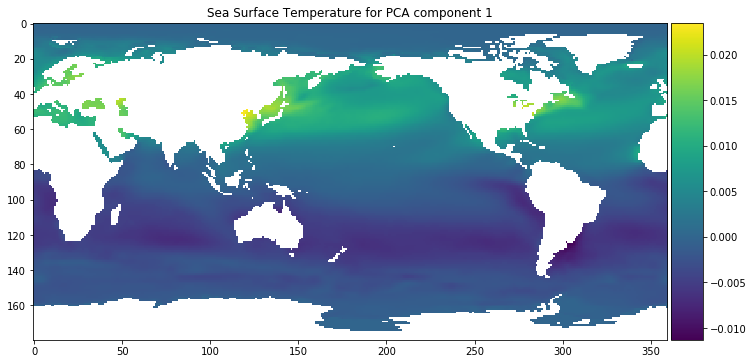

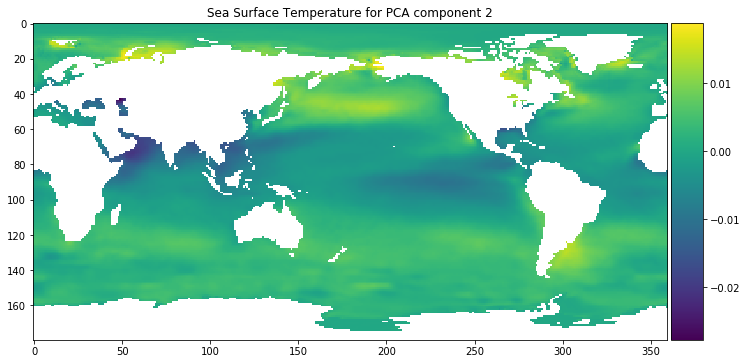

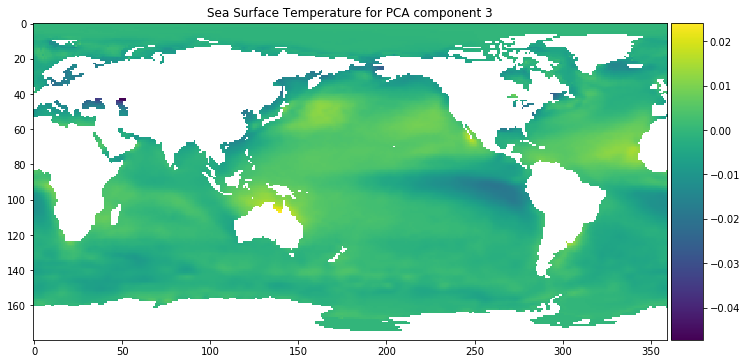

In [18]:
def colorbar_cartopy(mappable, cmap, **kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)   
    cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes, autoscale_on=False)
    obj = fig.colorbar(cmap, cax=cax, **kwargs)
    return obj

plt.close('all')

for i in range (3):
    f,ax = plt.subplots(figsize = (12,6))
    img = ax.imshow(sst_pca[i,:,:])
    plt.title('Sea Surface Temperature for PCA component {}'.format(i+1), loc = 'center')
    cb = colorbar_cartopy(ax, img)

**Question 3:** Interpretation of the results

The PCA with 5 components resulted in 5 data sets that represent the 91% of the data for the mean Sea Surface Temperature (SST) for the time period 1981-2010. The plots include the first 3 data sets and the bars are normalized.    

The first plot depicts the first dataset, which describes the 85% of the data.  It is very interesting to notice the difference between the warmer sea temperatures of the northern hemisphere, which is occupied by the larger part of the land and where the main part of human activities take place, and lower ones of the southern hemisphere, which is not that highly inhabited and contains mostly oceans. It is quite clear that the 'closed' seas, like the Mediterranean, the Baltic, the Red sea, and the seas around large cities and highly industrialized areas, like New York, Peijing, Hong Kong, are significantly warmer. 

The other two images represent the 2.7% and 2.1% of the data, which is quite low. We cannot extract any valuable conclusion from such restricted data. It is though quite interesting to notice some constant patters among all images, which can be attributed to corresponding sea currents, for instance the Northern Pacific and the Northen Equatorial current. 
